## Prompt Metadata

#### Metadata File to pandas dataframe

In [290]:
from src.utils import read_yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from src.factories import dataLoaderFactory, teacherResponseParserFactory
from src.teacher_response_evaluator import TeacherResponseEvaluator

In [291]:
def get_meta_df(dataset: str) -> pd.DataFrame:
    metadata = read_yaml(f"prompt-metadata/{dataset}.yaml")

    # flatten metadata and convert to dataframe
    metadata = {k: {**v['costs'], **v['characteristics'], **v['performance']} for k, v in metadata.items()}
    meta_df = pd.DataFrame.from_dict(metadata, orient='index')

    # Add PALM FewShot Performance to meta_df
    # Load PALM predictions and rationales
    
    dataset_loader = dataLoaderFactory(dataset)
    train_llm_rationales, train_llm_labels = dataset_loader.load_llm_preds(split="train")

    parsed_responses = {i: (label, rational) for i, (label, rational) in enumerate(zip(train_llm_labels, train_llm_rationales))}

    evaluator = TeacherResponseEvaluator(dataset)

    label_eval = evaluator.get_label_accuracy(split="train", parsed_responses=parsed_responses)
    rationale_eval = evaluator.get_explanation_characteristics(parsed_responses=parsed_responses)

    palm_eval = {"accuracy": label_eval[0],
             "n_correct": label_eval[1],
             "n_wrong": label_eval[2],
             "n_none_responses": rationale_eval[0],
             "total_responses": rationale_eval[1],
             "total_length_of_explanations": rationale_eval[2],
             "total_number_of_sentences": rationale_eval[3],
             "total_number_of_words": rationale_eval[4],
             "flesch_reading_ease": rationale_eval[5],
             "variance_length_of_explanations": rationale_eval[6],
             "avg_len_of_explanations": rationale_eval[2] / rationale_eval[1],
             "avg_nr_of_sentences": rationale_eval[3] / rationale_eval[1],
             "avg_nr_of_words": rationale_eval[4] / rationale_eval[1],
             "n_parse_errors": 0,
             }
    
    # insert PALM evaluation into metadata dataframe with index 0
    meta_df = pd.concat([pd.DataFrame(palm_eval, index=[0]), meta_df])

    # add column with explanation rate = total responses / (n_correct + n_wrong)
    meta_df["explanation_rate"] = meta_df["total_responses"] / (meta_df["n_correct"] + meta_df["n_wrong"])
    meta_df["sd_length_of_explanations"] = meta_df["variance_length_of_explanations"] ** 0.5

    return meta_df

In [3]:
## Check GPT35 performance on validation set
#test_gpt35_rationales, test_gpt35_labels = dataset_loader.load_gpt35_preds(split="valid", prompt_mix_id=6)
#parsed_responses_gpt35 = {i: (label, rational) for i, (label, rational) in enumerate(zip(test_gpt35_labels, test_gpt35_rationales))}
#evaluator.get_label_accuracy(split="valid", parsed_responses=parsed_responses_gpt35)

In [292]:
meta_df = get_meta_df("anli1")
meta_df.head()

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,avg_len_of_explanations,avg_nr_of_sentences,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,113.622389,1.490853,19.251151,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,51.859106
1,0.592000,74,51,0,125,15470,130,2583,47.30000,1687.254000,123.760000,1.040000,20.660000,0,0.00020,30.08,125.28,0.025320,125.0,3760.0,15660.0,1.00,41.076197
2,0.456000,57,68,0,125,21123,137,3396,40.80000,2083.536000,168.980000,1.100000,27.170000,0,0.00033,40.82,215.10,0.041242,125.0,5103.0,26887.0,1.00,45.645767
3,0.576000,72,53,125,0,0,0,0,0.00000,NaN,0.000000,0.000000,0.000000,0,0.00015,2.78,123.28,0.019296,125.0,347.0,15410.0,0.00,NaN
4,0.600000,30,20,2,48,15915,140,2580,46.50000,27909.496000,331.560000,2.920000,53.750000,1,0.00037,89.04,126.84,0.018417,50.0,4452.0,6342.0,0.96,167.061354


In [293]:
# sort meta_df by accuracy
pd.set_option('display.max_columns', None)
meta_df.sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,avg_len_of_explanations,avg_nr_of_sentences,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations
1000,0.999600,8470,3,0,8473,3782034,31511,627386,46.80000,7083.481000,446.360000,3.720000,74.050000,0,0.00200,93.98,1204.90,18.951492,9498.0,892644.0,11444136.0,1.000000,84.163418
179,0.995200,16865,81,170,16776,2286972,16893,387546,47.30000,1513.236000,136.320000,1.010000,23.100000,81,0.00030,39.89,145.82,5.356910,17946.0,715838.0,2616823.0,0.989968,38.900334
100,0.709800,12028,4918,2173,14773,3069997,24926,500537,43.10000,14076.337000,207.810000,1.690000,33.880000,45,0.00030,60.61,119.99,5.650959,18761.0,1137078.0,2251202.0,0.871769,118.643740
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,113.622389,1.490853,19.251151,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,51.859106
32,0.678300,78,37,20,95,16724,151,2739,51.00000,9259.830000,176.040000,1.590000,28.830000,0,0.00032,64.24,130.17,0.037231,115.0,7388.0,14970.0,0.826087,96.228010
28,0.660000,33,17,17,33,5441,42,878,40.40000,4813.622000,164.880000,1.270000,26.610000,0,0.00027,31.92,134.80,0.013302,50.0,1596.0,6740.0,0.660000,69.380271
149,0.660000,33,17,34,16,2825,22,461,47.00000,15896.996000,176.560000,1.380000,28.810000,0,0.00026,24.02,139.76,0.012884,50.0,1201.0,6988.0,0.320000,126.083290
134,0.640000,32,18,18,32,4467,49,729,52.40000,7051.679000,139.590000,1.530000,22.780000,0,0.00031,52.00,140.14,0.015710,50.0,2600.0,7007.0,0.640000,83.974276
58,0.640000,32,18,12,38,6087,51,995,46.80000,6441.098000,160.180000,1.340000,26.180000,0,0.00030,47.10,135.12,0.014844,50.0,2355.0,6756.0,0.760000,80.256451
163,0.640000,32,18,31,19,2353,26,381,50.10000,9929.922000,123.840000,1.370000,20.050000,6,0.00029,46.04,134.64,0.014702,50.0,2302.0,6732.0,0.380000,99.648994


## Plots

Text(0.5, 1.0, 'SD of Length of Explanations')

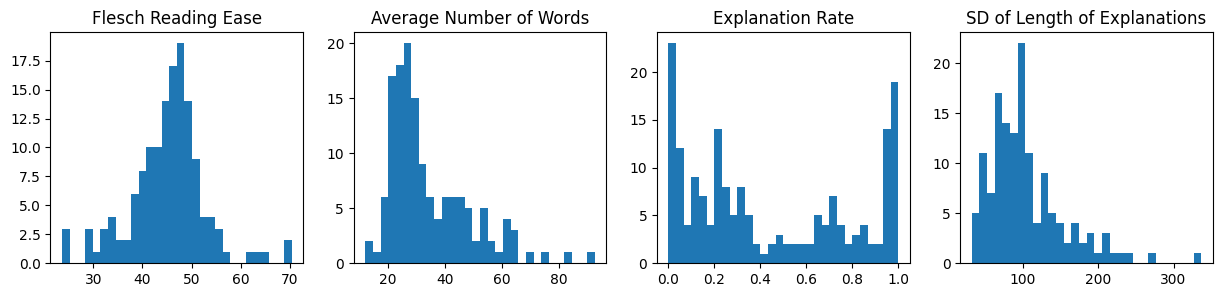

In [294]:
# histograms of: flesh reading ease, avg_nr_of_sentences, avg_nr_of_words, variance_length_of_explanations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
ax1.hist(meta_df[meta_df["total_responses"] >= 5]["flesch_reading_ease"], bins=30)
ax1.set_title("Flesch Reading Ease")
ax2.hist(meta_df[meta_df["total_responses"] >= 5]["avg_nr_of_words"], bins=30)
ax2.set_title("Average Number of Words")
ax3.hist(meta_df["explanation_rate"], bins=30)
ax3.set_title("Explanation Rate")
ax4.hist(meta_df[meta_df["total_responses"] >= 5]["sd_length_of_explanations"], bins=30)
ax4.set_title("SD of Length of Explanations")

Text(0.5, 1.05, 'Accuracy versus')

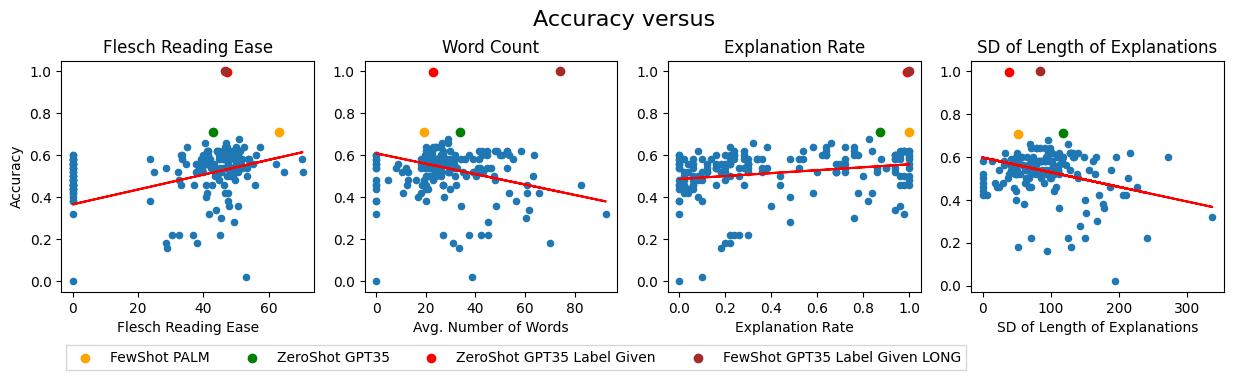

In [295]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))

reg_meta_df = meta_df[meta_df["total_responses"] >= 5].drop([0, 179, 1000], axis=0)
#reg_meta_df = meta_df[meta_df["total_responses"] >= 5].drop([0], axis=0)

meta_df.plot.scatter(x="flesch_reading_ease", y="accuracy", title="Flesch Reading Ease", ax=ax1)
slope, intercept = np.polyfit(reg_meta_df["flesch_reading_ease"], reg_meta_df["accuracy"], 1)
ax1.plot(meta_df["flesch_reading_ease"], slope*meta_df["flesch_reading_ease"] + intercept, color='red')

meta_df.plot.scatter(x="avg_nr_of_words", y="accuracy", title="Word Count", ax=ax2)
slope, intercept = np.polyfit(reg_meta_df["avg_nr_of_words"], reg_meta_df["accuracy"], 1)
ax2.plot(meta_df["avg_nr_of_words"], slope*meta_df["avg_nr_of_words"] + intercept, color='red')

meta_df.plot.scatter(x="explanation_rate", y="accuracy", title="Explanation Rate", ax=ax3)
slope, intercept = np.polyfit(reg_meta_df["explanation_rate"], reg_meta_df["accuracy"], 1)
ax3.plot(meta_df["explanation_rate"], slope*meta_df["explanation_rate"] + intercept, color='red')

meta_df.plot.scatter(x="sd_length_of_explanations", y="accuracy", title="SD of Length of Explanations", ax=ax4)
slope, intercept = np.polyfit(reg_meta_df["sd_length_of_explanations"], reg_meta_df["accuracy"], 1)
ax4.plot(meta_df["sd_length_of_explanations"], slope*meta_df["sd_length_of_explanations"] + intercept, color='red')

HIGHLIGHTS = [(0, "orange", "FewShot PALM"), (100, "green", "ZeroShot GPT35"), (179, "red", "ZeroShot GPT35 Label Given"), (1000, "brown", "FewShot GPT35 Label Given LONG")]
#HIGHLIGHTS = [(0, "orange", "FewShot PALM"), (3, "green", "ZeroShot GPT35")]


for HL  in HIGHLIGHTS:
    ax1.scatter(meta_df.loc[HL[0]]['flesch_reading_ease'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax2.scatter(meta_df.loc[HL[0]]['avg_nr_of_words'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax3.scatter(meta_df.loc[HL[0]]['explanation_rate'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax4.scatter(meta_df.loc[HL[0]]['sd_length_of_explanations'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])

#ax1.axhline(y=meta_df.iloc[0]['accuracy'], color='red', linestyle='-', lw=0.5)

ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Flesch Reading Ease")
ax2.set_ylabel("")
ax2.set_xlabel("Avg. Number of Words")
ax3.set_ylabel("")
ax3.set_xlabel("Explanation Rate")
ax4.set_ylabel("")
ax4.set_xlabel("SD of Length of Explanations")
ax1.legend(bbox_to_anchor=(1.8, -0.2), loc='upper center', ncol=4, fancybox=False)

plt.suptitle('Accuracy versus', y=1.05, fontsize=16)

Good prompts, that deliver the most accurate results, seem to produce short (between 20 and 30 words), high FRE (above 45) explanations.

There seem to be the following tendencies:
 - The lower the FRE, the lower the accuracy. So complicated explanations are not good for the prediction.
 - The longer the explanation, the lower the accuracy. So long explanations are not good for the prediction.
 - However, very short explanations (< 20 words) are also not good for the prediction.
 - Wether a prompt makes the model return an explanation at all, does not seem to have an influence on the accuracy.

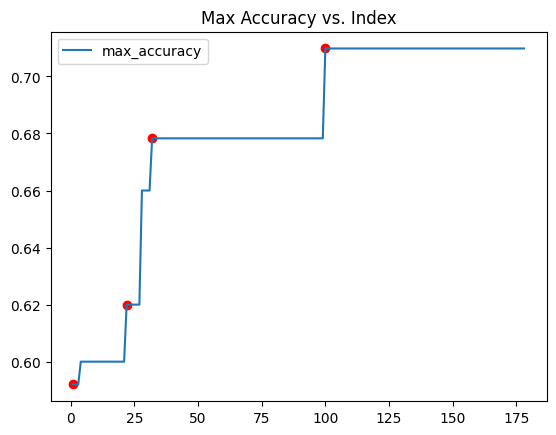

In [298]:
meta_df["max_accuracy"] = meta_df.drop([0, 179, 1000], axis=0)["accuracy"].cummax()
#meta_df["max_accuracy"] = meta_df.drop([0], axis=0)["accuracy"].cummax()
meta_df.plot.line(y="max_accuracy", title="Max Accuracy vs. Index")

# plot a red point at index 100
plt.scatter(1, meta_df.loc[1]['max_accuracy'], color='red')
plt.scatter(22, meta_df.loc[22]['max_accuracy'], color='red')
plt.scatter(32, meta_df.loc[32]['max_accuracy'], color='red')
plt.scatter(100, meta_df.loc[100]['max_accuracy'], color='red')

#plt.scatter(1, meta_df.loc[1]['max_accuracy'], color='red')
#plt.scatter(3, meta_df.loc[3]['max_accuracy'], color='red')
#plt.scatter(6, meta_df.loc[6]['max_accuracy'], color='red')

In [299]:
pd.set_option('display.max_columns', 30)
meta_df[(meta_df["avg_nr_of_words"] > 30) & (meta_df["avg_nr_of_words"] > 70)].sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,avg_len_of_explanations,avg_nr_of_sentences,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations,max_accuracy
1000,0.9996,8470,3,0,8473,3782034,31511,627386,46.8,7083.481,446.36,3.72,74.05,0,0.00200,93.98,1204.90,18.951492,9498.0,892644.0,11444136.0,1.00,84.163418,NaN
144,0.4600,23,27,1,49,25220,199,4042,42.8,51120.172,514.69,4.06,82.49,1,0.00048,143.62,129.14,0.024048,50.0,7181.0,6457.0,0.98,226.097705,0.7098
26,0.3200,16,34,1,49,28614,236,4536,41.6,113655.468,583.96,4.82,92.57,1,0.00051,148.92,138.76,0.025299,50.0,7446.0,6938.0,0.98,337.128266,0.6200
173,0.1800,9,41,40,10,4556,31,702,28.6,16902.640,455.60,3.10,70.20,39,0.00038,93.68,125.14,0.018753,50.0,4684.0,6257.0,0.20,130.010153,0.7098


## Training Results

In [363]:
experiments = pd.read_csv('experiment-tracking/experiment_tracking.csv')
experiments["llm"] = experiments["llm"].fillna("None")
experiments.head()

,experiment_group,category,dataset,model,mode,llm,subsample,prompt_mix,label_type,alpha,max_input_length,batch_size,optimizer,lr,run,train_duration,train_steps,test_acc,eval_acc
0,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.125,0,gt,0.5,1024,64,AdamW,0.00005,0,2528.0,3750,0.349,0.347
1,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.250,0,gt,0.5,1024,64,AdamW,0.00005,0,3738.0,5500,0.434,0.403
2,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.500,0,gt,0.5,1024,64,AdamW,0.00005,0,8497.0,9500,0.346,0.342
3,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,1.000,0,gt,0.5,1024,64,AdamW,0.00005,0,5848.0,6500,0.341,0.334
4,MANUAL Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.125,0,gt,0.5,1024,64,AdamW,0.00005,100,10000.0,3750,0.349,0.347


## Subsampling

In [320]:
def subsampling_graph(experiments_data: pd.DataFrame, dataset: str, labels: bool, prompt_mix: int, distill_labels: str = None):
    # Toggle Manual Corrections
    #experiments_data = experiments_data[~experiments_data["experiment_group"].str.contains("MANUAL")]

    experiments_data = experiments_data.query("dataset == @dataset and model == 't5-v1_1-base' and prompt_mix in [0, @prompt_mix]")
    if labels:
        experiments_data = experiments_data.query("label_type == 'gt'")
    else:
        experiments_data = experiments_data.query("label_type == 'llm'")

    # group over runs and add mean and standard error over top 3 runs
    experiments_data = experiments_data.groupby(["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).apply(
        lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True).groupby(
            ["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).agg(
                {"train_duration": ["mean", "std"],
                "train_steps": ["mean", "std"],
                "test_acc": ["mean", "std", "sem"],
                "eval_acc": ["mean", "std", "sem", "max"]}
                )
    
    # flatten multiindex
    experiments_data.columns = ["_".join(col) for col in experiments_data.columns.ravel()]
    experiments_data = experiments_data.reset_index()

    if labels:
        standard = experiments_data.query("mode == 'standard' and llm == 'None'")
    else:
        standard = experiments_data.query("mode == 'standard' and llm == @distill_labels") ## For standard distillation we have to set labels to gpt35 or palm
    task_prefix_palm = experiments_data.query("mode == 'task_prefix' and llm == 'palm'")
    task_prefix_gpt35 = experiments_data.query("mode == 'task_prefix' and llm == 'gpt35'")

    fig, ax = plt.subplots()

    lb = "standard" if labels else f"standard ({distill_labels.upper()})"
    ax.plot(standard["subsample"], standard["eval_acc_mean"], label=lb, color="blue", marker="o")
    ax.fill_between(standard["subsample"], standard["eval_acc_mean"] - standard["eval_acc_sem"], standard["eval_acc_mean"] + standard["eval_acc_sem"], alpha=0.2)

    # add dotted horizontal line for accuracy of standard at subsample 1
    ax.axhline(y=standard[standard["subsample"] == 1.0]["eval_acc_mean"].values[0], xmin=0.0475, xmax=0.95, color='blue', linestyle='--')

    ax.plot(task_prefix_palm["subsample"], task_prefix_palm["eval_acc_mean"], label="step-by-step PALM", color="orange", marker="^")
    ax.fill_between(task_prefix_palm["subsample"], task_prefix_palm["eval_acc_mean"] - task_prefix_palm["eval_acc_sem"], task_prefix_palm["eval_acc_mean"] + task_prefix_palm["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_gpt35["subsample"], task_prefix_gpt35["eval_acc_mean"], label=f"step-by-step GPT35 ({prompt_mix})", color="green", marker="d")
    ax.fill_between(task_prefix_gpt35["subsample"], task_prefix_gpt35["eval_acc_mean"] - task_prefix_gpt35["eval_acc_sem"], task_prefix_gpt35["eval_acc_mean"] + task_prefix_gpt35["eval_acc_sem"], alpha=0.2)

    # set x ticks to subsample values and add grid lines to x and y axis
    ax.set_xticks(standard["subsample"])
    ax.grid(axis="x")
    ax.grid(axis="y")

    title = "Finetuning - Eval Accuracy vs. Subsample" if labels else f"Distillation - Eval Accuracy vs. Subsample"
    ax.set_title(title)
    ax.set_ylabel("Eval Accuracy")
    ax.set_xlabel("Subsample")
    ax.legend()

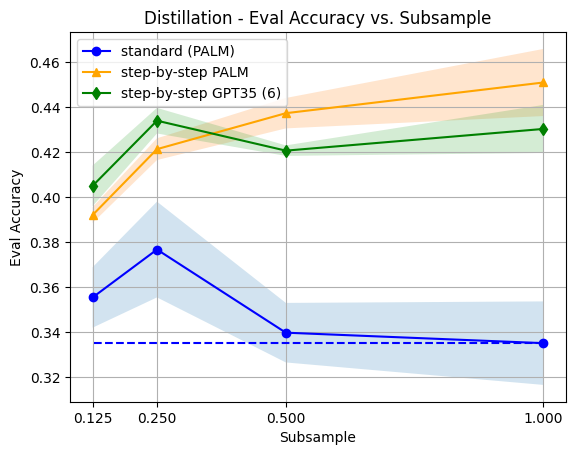

In [375]:
subsampling_graph(experiments, dataset="anli1", labels=False, prompt_mix=6, distill_labels="palm")

## Model Size

In [304]:
def modelsize_graph(experiments_data: pd.DataFrame, dataset: str, labels: bool, prompt_mix: int, distill_labels: str = None):
    # replace nan with "None"
    experiments_data["llm"] = experiments_data["llm"].fillna("None")

    experiments_data = experiments_data.query("dataset == @dataset and subsample == 1.0 and prompt_mix in [0, @prompt_mix]")
    if labels:
        experiments_data = experiments_data.query("label_type == 'gt'")
    else:
        experiments_data = experiments_data.query("label_type == 'llm'")

    # group over runs and add mean and standard error over top 3 runs
    experiments_data = experiments_data.groupby(["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).apply(
        lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True).groupby(
            ["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).agg(
                {"train_duration": ["mean", "std"],
                "train_steps": ["mean", "std"],
                "test_acc": ["mean", "std", "sem"],
                "eval_acc": ["mean", "std", "sem", "max"]}
                )
    
    # flatten multiindex
    experiments_data.columns = ["_".join(col) for col in experiments_data.columns.ravel()]
    experiments_data = experiments_data.reset_index()

    # add int model size column
    sizes = {"t5-v1_1-base": 250, "t5-v1_1-small": 77, "t5-v1_1-large": 800, "t5-v1_1-xl": 3000}
    experiments_data["model_size"] = experiments_data["model"].map(sizes)

    # sort by model size
    experiments_data = experiments_data.sort_values(by=["model_size"])

    if labels:
        standard = experiments_data.query("mode == 'standard' and llm == 'None'")
    else:
        standard = experiments_data.query("mode == 'standard' and llm == @distill_labels") ## For standard distillation we have to set labels to gpt35 or palm
    task_prefix_palm = experiments_data.query("mode == 'task_prefix' and llm == 'palm'")
    task_prefix_gpt35 = experiments_data.query("mode == 'task_prefix' and llm == 'gpt35'")

    fig, ax = plt.subplots()

    lb = "standard" if labels else f"standard ({distill_labels.upper()})"
    ax.plot(standard["model_size"], standard["eval_acc_mean"], label=lb, color="blue", marker="o")
    ax.fill_between(standard["model_size"], standard["eval_acc_mean"] - standard["eval_acc_sem"], standard["eval_acc_mean"] + standard["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_palm["model_size"], task_prefix_palm["eval_acc_mean"], label="step-by-step PALM", color="orange", marker="^")
    ax.fill_between(task_prefix_palm["model_size"], task_prefix_palm["eval_acc_mean"] - task_prefix_palm["eval_acc_sem"], task_prefix_palm["eval_acc_mean"] + task_prefix_palm["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_gpt35["model_size"], task_prefix_gpt35["eval_acc_mean"], label=f"step-by-step GPT35 ({prompt_mix})", color="green", marker="d")
    ax.fill_between(task_prefix_gpt35["model_size"], task_prefix_gpt35["eval_acc_mean"] - task_prefix_gpt35["eval_acc_sem"], task_prefix_gpt35["eval_acc_mean"] + task_prefix_gpt35["eval_acc_sem"], alpha=0.2)

    # set x ticks to subsample values and add grid lines to x and y axis
    ax.set_xticks(standard["model_size"])
    ax.set_xticklabels(["77M", "250M", "800M", "3B"], rotation=45)
    ax.grid(axis="x")
    ax.grid(axis="y")

    title = "Finetuning - Eval Accuracy vs. Model Size" if labels else f"Distillation - Eval Accuracy vs. Model Size"
    ax.set_title(title)
    ax.set_ylabel("Eval Accuracy")
    ax.set_xlabel("Model Size")
    ax.legend()

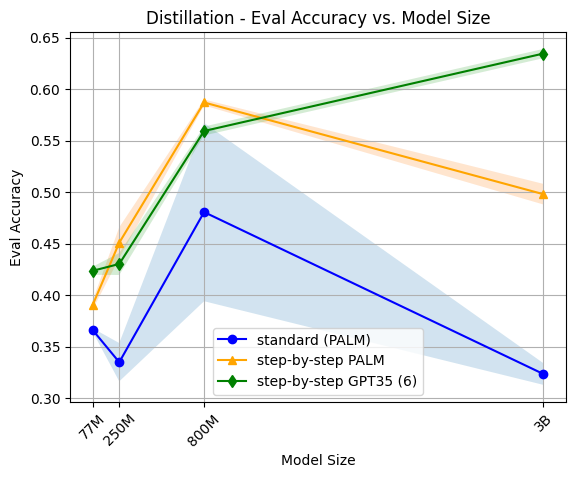

In [374]:
modelsize_graph(experiments, dataset="anli1", labels=False, prompt_mix=6, distill_labels="palm")

## Explanation Sytle
### Length

Text(0.5, 1.05, 'Eval Accuracy vs. Average Length of Explanation across Model Sizes (SubSample=0.5)')

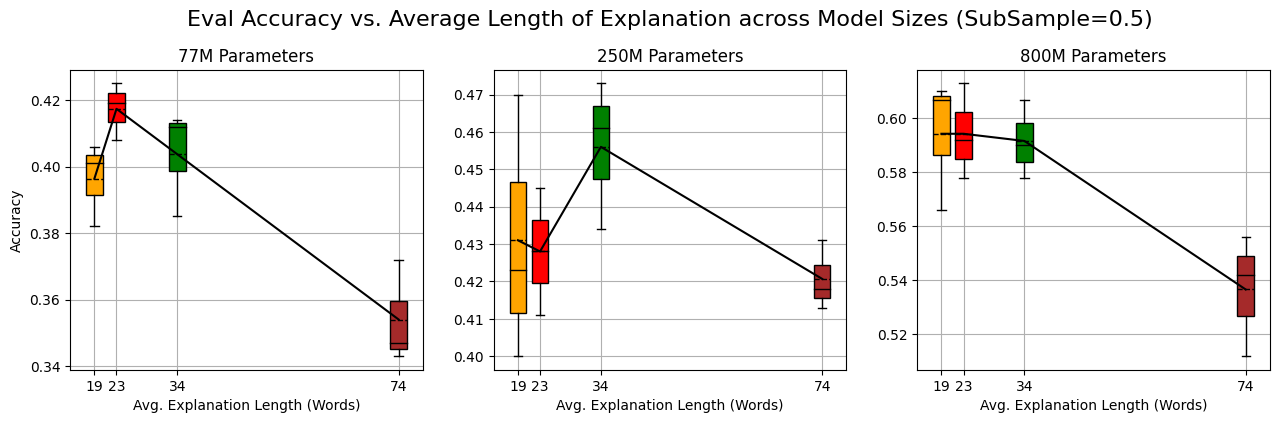

In [352]:
filtered_exp_length_cp = experiments.copy()
# for prompt_mix 9, change subsample 1.0 to 0.5
filtered_exp_length_cp.loc[(filtered_exp_length_cp["prompt_mix"] == 9), "subsample"] = 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
models = ["t5-v1_1-small", "t5-v1_1-base", "t5-v1_1-large"]
model_sizes = ["77M", "250M", "800M"]
for ax, model, size in zip([ax1, ax2, ax3], models, model_sizes):

    filtered_exp_length = filtered_exp_length_cp.query("dataset == 'anli1' and model == @model and subsample == 0.5 and label_type == 'gt' and mode == 'task_prefix'")
    
    # group over runs and add mean and standard error over top 3 runs
    filtered_exp_length = filtered_exp_length.groupby(["prompt_mix"]).apply(
        lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True)

    lens = {0: 19, 6: 34, 8: 23, 9: 74}
    filtered_exp_length["avg_x_len"] = filtered_exp_length["prompt_mix"].map(lens)
    filtered_exp_length = filtered_exp_length.sort_values(by=["avg_x_len"])

    # vertical boxplots of eval_acc for each avg_x_len.
    positions = sorted(lens.values())
    colors = ["orange", "red", "green", "brown"]
    bplot = filtered_exp_length.boxplot(column="eval_acc", by="avg_x_len", ax=ax, positions=positions, grid=True, widths=3.0, patch_artist=True, 
                                        boxprops=dict(edgecolor="black"),
                                        medianprops=dict(color="black", linewidth=1),
                                        meanprops=dict(color="black", linewidth=1),
                                        whiskerprops=dict(color="black"),
                                        showfliers=False,
                                        showmeans=True, meanline=True)
    boxes = [child for child in bplot.get_children() if isinstance(child, matplotlib.patches.PathPatch)]
    for box, color in zip(boxes, colors):
        box.set_facecolor(color)

    ax.plot(positions, filtered_exp_length.groupby(["avg_x_len"]).agg({"eval_acc": "mean"}), color="black", marker="")
    ax.set_title(f"{size} Parameters")
    ax.set_xlabel("Avg. Explanation Length (Words)")
    
ax1.set_ylabel("Accuracy")
fig.suptitle("Eval Accuracy vs. Average Length of Explanation across Model Sizes (SubSample=0.5)", y=1.05, fontsize=16)

### Explanation Rate

Text(0.5, 0.98, '')

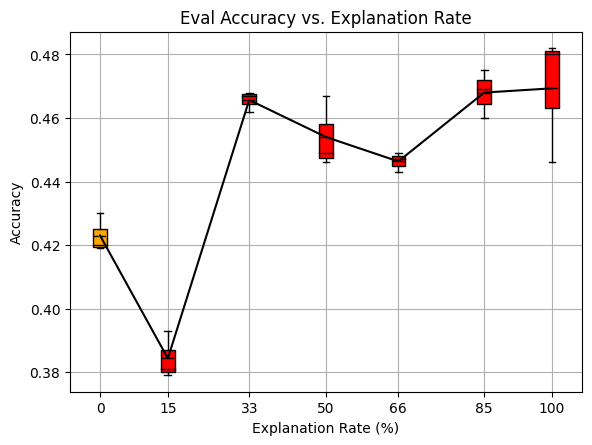

In [376]:
filtered_exp_rate = experiments.copy()

filtered_exp_rate = filtered_exp_rate.query("(dataset == 'anli1' and model == 't5-v1_1-base' and subsample == 1.0 and label_type == 'gt' and mode == 'task_prefix' and prompt_mix in [8, 10, 11, 12, 13, 14]) or (dataset == 'anli1' and model == 't5-v1_1-base' and subsample == 1.0 and label_type == 'gt' and mode == 'standard' and prompt_mix == 0)")


# group over runs and add mean and standard error over top 3 runs
filtered_exp_rate = filtered_exp_rate.groupby(["prompt_mix"]).apply(
    lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True)

xr = {0: 0, 8: 100, 10: 66, 11: 33, 12: 50, 13: 15, 14: 85}
filtered_exp_rate["xr"] = filtered_exp_rate["prompt_mix"].map(xr)
filtered_exp_rate = filtered_exp_rate.sort_values(by=["xr"])

fig, ax = plt.subplots()

positions = sorted(xr.values())
colors = ["orange", "yellow", "pink", "lightblue", "grey", "purple", "red"]
colors = ["orange", "red", "red", "red", "red", "red", "red"]
bplot = filtered_exp_rate.boxplot(column="eval_acc", by="xr", ax=ax, positions=positions, grid=True, widths=3.0, patch_artist=True, 
                                    boxprops=dict(edgecolor="black"),
                                    medianprops=dict(color="black", linewidth=1),
                                    meanprops=dict(color="black", linewidth=1),
                                    whiskerprops=dict(color="black"),
                                    showfliers=False,
                                    showmeans=True, meanline=True)
boxes = [child for child in bplot.get_children() if isinstance(child, matplotlib.patches.PathPatch)]
for box, color in zip(boxes, colors):
    box.set_facecolor(color)

ax.plot(positions, filtered_exp_rate.groupby(["xr"]).agg({"eval_acc": "mean"}), color="black", marker="")
ax.set_title("Eval Accuracy vs. Explanation Rate")
ax.set_xlabel("Explanation Rate (%)")
ax.set_ylabel("Accuracy")
fig.suptitle("")